In [1]:
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr 
import matplotlib.pyplot as plt 

import datetime 
import torch 
import torch.nn as nn 
from torch.autograd import Variable 

import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
df = pd.read_csv("/home/smsung/Downloads/MilliCar-SUMO/Test/Test_data_220120/cv_s60_i0.0_k0.0_a0.0_l_S_Highway.txt",sep='\t', names=['seq','speed','IR','Pathloss','dist','WA','WC','SC'])
df2 = pd.read_csv("/home/smsung/Downloads/MilliCar-SUMO/Test/Test_data_220120/cv_s60_i0.0_k0.0_a0.0_l_S_Urban.txt",sep='\t', names=['seq','speed','IR','Pathloss','dist','WA','WC','SC'])

dfplt = df['Pathloss']
df2plt = df2['Pathloss']

# dfplt.plot(figsize=(20,12), grid=True) #plotting
# df2plt.plot(figsize=(20,12), grid=True)

seq = df['seq']

df = df.drop(columns='SC')
X = df.drop(columns='Pathloss')
y = df.iloc[:,3:4] 

X, y

(      seq  speed  IR     dist  WA  WC
 0     0.0     60   0  1457.01   0   1
 1     0.1     60   0  1455.34   0   1
 2     0.2     60   0  1453.68   0   1
 3     0.3     60   0  1452.01   0   1
 4     0.4     60   0  1450.35   0   1
 ..    ...    ...  ..      ...  ..  ..
 795  79.5     60   0  1227.81   0   1
 796  79.6     60   0  1229.48   0   1
 797  79.7     60   0  1231.14   0   1
 798  79.8     60   0  1232.81   0   1
 799  79.9     60   0  1234.47   0   1
 
 [800 rows x 6 columns],
      Pathloss
 0     133.980
 1     136.677
 2     128.739
 3     134.745
 4     134.735
 ..        ...
 795   131.148
 796   131.160
 797   131.172
 798   131.184
 799   131.195
 
 [800 rows x 1 columns])

In [3]:
# plt.rcParams["figure.figsize"]  = (20,12)
# plt.scatter(df['seq'], df['Pathloss'], s=1)
# plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
mm = MinMaxScaler() 
ss = StandardScaler() 

X_ss = ss.fit_transform(X) 
y_mm = mm.fit_transform(y) 

# Train Data 
X_train = X_ss[:680, :] 
X_test = X_ss[680:, :] 

# Test Data 
""" ( 얼마나 예측데이터와 실제 데이터의 정확도를 확인하기 위해 
from sklearn.metrics import accuracy_score 를 통해 정확한 값으로 확인할 수 있다. ) """ 
y_train = y_mm[:680, :] 
y_test = y_mm[680:, :] 

print("Training Shape", X_train.shape, y_train.shape) 
print("Testing Shape", X_test.shape, y_test.shape)

X_train_tensors = Variable(torch.Tensor(X_train)) 
X_test_tensors = Variable(torch.Tensor(X_test)) 

y_train_tensors = Variable(torch.Tensor(y_train)) 
y_test_tensors = Variable(torch.Tensor(y_test)) 

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])) 
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape) 
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape (680, 6) (680, 1)
Testing Shape (120, 6) (120, 1)
Training Shape torch.Size([680, 1, 6]) torch.Size([680, 1])
Testing Shape torch.Size([120, 1, 6]) torch.Size([120, 1])


In [5]:
class LSTM1(nn.Module): 
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length): 
        super(LSTM1, self).__init__() 
        self.num_classes = num_classes #number of classes 
        self.num_layers = num_layers #number of layers 
        self.input_size = input_size #input size 
        self.hidden_size = hidden_size #hidden state 
        self.seq_length = seq_length #sequence length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                           num_layers=num_layers, batch_first=True) #lstm 
        self.fc_1 = nn.Linear(hidden_size, 256) #fully connected 1 
        self.fc = nn.Linear(256, num_classes) #fully connected last layer 
        self.relu = nn.ReLU() 

    def forward(self,x): 
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state 
        # Propagate input through LSTM 
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state 
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next 
        out = self.relu(hn) 
        out = self.fc_1(out) #first Dense 
        out = self.relu(out) #relu 
        out = self.fc(out) #Final Output 

        return out

num_epochs = 2000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 6 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

for epoch in range(num_epochs): 
    outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass 
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0 

  # obtain the loss function 
    loss = loss_function(outputs, y_train_tensors.to(device)) 

    loss.backward() #calculates the loss of the loss function 

    optimizer.step() #improve from loss, i.e backprop 
    if epoch % 100 == 0: 
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

df_X_ss = ss.transform(df.drop(columns='Pathloss'))
df_y_mm = mm.transform(df.iloc[:, 3:4])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))


#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

# model = LSTM1()

print(loss_function)
# plt.plot(LSTM1.history['acc'])
# plt.plot(LSTM1.history['val_acc'])
# plt.show()
# plt.plot(LSTM1.history['loss'])
# plt.plot(LSTM1.history['val_loss'])
# plt.show()


Epoch: 0, loss: 0.38825
Epoch: 100, loss: 0.01778
Epoch: 200, loss: 0.00555
Epoch: 300, loss: 0.00511
Epoch: 400, loss: 0.00480
Epoch: 500, loss: 0.00462
Epoch: 600, loss: 0.00450
Epoch: 700, loss: 0.00415
Epoch: 800, loss: 0.00398
Epoch: 900, loss: 0.00392
Epoch: 1000, loss: 0.00390
Epoch: 1100, loss: 0.00388
Epoch: 1200, loss: 0.00386
Epoch: 1300, loss: 0.00385
Epoch: 1400, loss: 0.00383
Epoch: 1500, loss: 0.00381
Epoch: 1600, loss: 0.00380
Epoch: 1700, loss: 0.00378
Epoch: 1800, loss: 0.00376
Epoch: 1900, loss: 0.00375
MSELoss()


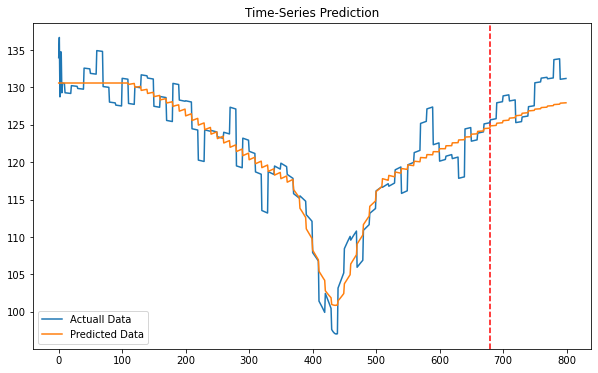

In [6]:
plt.rcParams["figure.figsize"]  = (10,6)
plt.axvline(x=680, c='r', linestyle='--') #size of the training set
plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.plot(grid = True)
plt.title('Time-Series Prediction')
plt.legend()
plt.show()